# runs parcels on existing netcdf files

relies on the files generated by `access_thredds` notebook as well as the `gapfilling` notebook (to get interpolated vector fields)

In [1]:
%matplotlib inline

In [2]:
import math
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from parcels import FieldSet, ParticleSet
from parcels import AdvectionRK4
from datetime import timedelta, datetime

### netcdf files

the selected file must also have an interpolated version of it generated by `gapfilling`

this is for running comparisons mostly

In [3]:
# 6 km res files
# category = "west_coast_6km_hourly"
# filename = "west_coast_6km_hourly_netcdfs/west_coast_6km_hourly_region0.nc"

# 2 km res files
# category = "west_coast_2km_hourly"
# filename = "west_coast_2km_hourly_netcdfs/west_coast_2km_hourly_region0.nc"

# 1 km res files
category = "west_coast_1km_hourly"
filename = "west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river.nc"

filename_interp = filename.split(".nc")[0] + "_interped.nc"

## setup: open the file as xarray first

load into xarray first so you actually have the time data, and don't have to deal with `deferred_load`

`deferred_load` likes to make time data disappear

In [4]:
fs_xr = xr.open_dataset(filename)
fs_xr

<xarray.Dataset>
Dimensions:                (lat: 20, lon: 17, nv: 2, time: 169, time_1: 1)
Coordinates:
  * lat                    (lat) float32 32.53346 32.54245 ... 32.69528 32.70427
  * lon                    (lon) float32 -117.28391 -117.2735 ... -117.11733
  * time                   (time) datetime64[ns] 2020-06-16T21:00:00 ... 2020-06-23T21:00:00
    time_run               (time) datetime64[ns] ...
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 ...
    depth_bnds             (nv) float32 ...
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    time_offset            (time) datetime64[ns] ...
    u                      (time, lat, lon) float32 ...
    v                      (time, lat, lon) float32 ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202007060600siohfruwlsrtvuswc1km
    date_created:              2020-07-06T07:48:41Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        30.25
    geospatial_lat_max:        49.99204
    geospatial_lon_min:        -130.36
    geospatial_lon_max:        -115.805565
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2020-07-06T07:19:24Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_1km_Resolutio...

In [5]:
fs_xr_interped = xr.open_dataset(filename_interp)
fs_xr_interped

<xarray.Dataset>
Dimensions:                (lat: 20, lon: 17, nv: 2, time: 169, time_1: 1)
Coordinates:
  * lat                    (lat) float32 32.53346 32.54245 ... 32.69528 32.70427
  * lon                    (lon) float32 -117.28391 -117.2735 ... -117.11733
  * time                   (time) datetime64[ns] 2020-06-16T21:00:00 ... 2020-06-23T21:00:00
    time_run               (time) datetime64[ns] ...
Dimensions without coordinates: nv, time_1
Data variables:
    time_bnds              (time_1, nv) int32 ...
    depth_bnds             (nv) float32 ...
    wgs84                  int8 ...
    processing_parameters  int8 ...
    radial_metadata        int8 ...
    depth                  float32 ...
    time_offset            (time) datetime64[ns] ...
    dopx                   (time, lat, lon) float32 ...
    dopy                   (time, lat, lon) float32 ...
    hdop                   (time, lat, lon) float32 ...
    number_of_sites        (time, lat, lon) float32 ...
    number_of_radials      (time, lat, lon) float32 ...
    u                      (time, lat, lon) float64 ...
    v                      (time, lat, lon) float64 ...
Attributes:
    Conventions:               CF-1.4, ACDD-1.3
    id:                        202007060600siohfruwlsrtvuswc1km
    date_created:              2020-07-06T07:48:41Z
    source:                    surface ocean velocity field from hf-radar
    program:                   Integrated Ocean Observing System (IOOS)
    title:                     Near-Real Time Surface Ocean Velocity, U.S. We...
    summary:                   Surface ocean velocities estimated from HF-Rad...
    instrument:                Earth Remote Sensing Instruments, Active Remot...
    keywords:                  Earth Science, Oceans, Sea Surface, Coastal Pr...
    geospatial_lat_min:        30.25
    geospatial_lat_max:        49.99204
    geospatial_lon_min:        -130.36
    geospatial_lon_max:        -115.805565
    processing_level:          Near real-time dataset with automated data acq...
    history:                   2020-07-06T07:19:24Z hfrnet rtvMergeData: Savi...
    references:                Terrill, E. et al., 2006. Data Management and ...
    institution:               Coastal Observing Research and Development Cen...
    creator_type:              group
    creator_name:              HFRNet Administrators
    creator_email:             hfrnet.administrators@sio.ucsd.edu
    creator_url:               http://cordc.ucsd.edu/projects/mapping/
    naming_authority:          edu.ucsd.cordc
    standard_name_vocabulary:  CF Standard Name Table, Version 51
    keywords_vocabulary:       Global Change Master Directory (GCMD) Keywords...
    instrument_vocabulary:     Global Change Master Directory (GCMD) Keywords...
    format_version:            1.1.00
    product_version:           2.0.00
    _CoordSysBuilder:          ucar.nc2.dataset.conv.CF1Convention
    cdm_data_type:             GRID
    featureType:               GRID
    location:                  Proto fmrc:HFRADAR_US_West_Coast_1km_Resolutio...

In [6]:
lat_range = (float(fs_xr["lat"].min()), float(fs_xr["lat"].max()))
lon_range = (float(fs_xr["lon"].min()), float(fs_xr["lon"].max()))
print(lat_range, lon_range)

(32.5334587097168, 32.70426940917969) (-117.2839126586914, -117.1173324584961)


In [7]:
fs = FieldSet.from_xarray_dataset(fs_xr, dict(U="u",V="v"), dict(lat="lat",lon="lon",time="time"))
fs_interped = FieldSet.from_xarray_dataset(fs_xr_interped, dict(U="u",V="v"), dict(lat="lat",lon="lon",time="time"))

# needed in case you want to generate the regions again without restarting this notebook
fs_xr.close()
fs_xr_interped.close()

/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


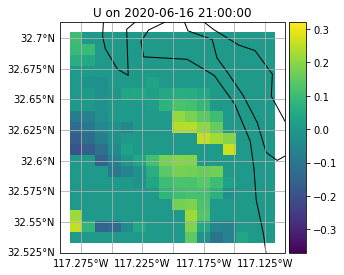

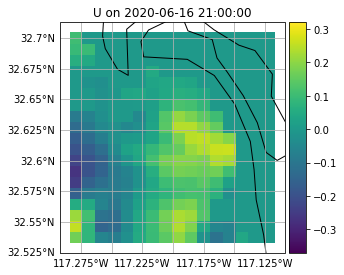

In [8]:
fs.U.show()
fs_interped.U.show()

In [9]:
time_range = fs.gridset.dimrange("time")
time_range

(0.0, 604800.0)

## Animated gif stuff and particle simulation

because it looks cool

In [10]:
# animation man very cool
# reference tutorial_Agulhasparticles
# needs ErrorCode for particle recovery
from operator import attrgetter
from parcels import ErrorCode, JITParticle, Variable

max_v = 1.1

interp = "linear"
fs.U.interp_method = interp
fs.V.interp_method = interp
fs_interped.U.interp_method = interp
fs_interped.V.interp_method = interp

class TimedParticle(JITParticle):
    lifetime = Variable("lifetime", initial=0, dtype=np.float32)
    spawntime = Variable("spawntime", initial=attrgetter("time"), dtype=np.float32)
    
def ParticleLifetime(particle, fieldset, time):
    particle.lifetime += particle.dt

def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
def exec_save_pset(pset, path, runtime, dt, maxv):
    pset.show(savefile=path, field='vector', land=True, vmax=maxv)
    
    # temporary - TODO make it only init once
    k_plifetime = pset.Kernel(ParticleLifetime)
    
    pset.execute(AdvectionRK4 + k_plifetime,
                 runtime=timedelta(seconds=runtime),
                 dt=timedelta(seconds=dt),
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

### set up particle spawn points

currently works where particles are generated at random positions with a bit of variations, and are released at set intervals.

In [11]:
repeat_dt = timedelta(hours=4)
particles_per_dt = 10
max_variation = 0.0015
spawn_points = np.array([
#     (32.551707, -117.136)
    (32.551707, -117.137)
])

repetitions = math.floor(time_range[1] / repeat_dt.total_seconds())
total = repetitions * particles_per_dt
lat_arr = np.zeros(total)
lon_arr = np.zeros(total)
time_arr = np.zeros(total)
for i in range(repetitions):
    time_arr[particles_per_dt * i:particles_per_dt * (i + 1)] = repeat_dt.seconds * i

sp_lat = spawn_points.T[0][np.random.randint(0, len(spawn_points), total)]
sp_lon = spawn_points.T[1][np.random.randint(0, len(spawn_points), total)]
variances_lat = (np.random.random(total) * 2 - 1) * max_variation
variances_lon = (np.random.random(total) * 2 - 1) * max_variation

p_lats = sp_lat + variances_lat
p_lons = sp_lon + variances_lon

In [12]:
pset = ParticleSet(fieldset=fs, pclass=TimedParticle, lon=p_lons, lat=p_lats, time=time_arr)
pset_interped = ParticleSet(fieldset=fs_interped, pclass=TimedParticle, lat=p_lats, lon=p_lons, time=time_arr)

/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:188: RuntimeWarning: invalid value encountered in true_divide
  v = np.where(speed > 0., data[1]/speed, 0)


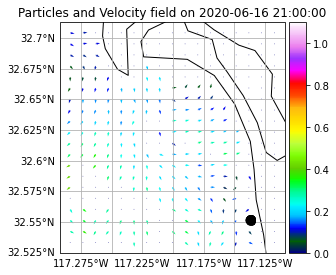

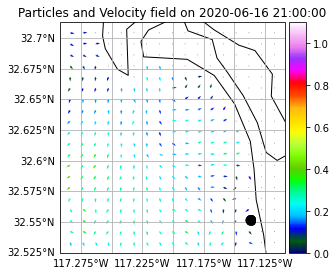

In [13]:
pset.show(field="vector", vmax=max_v)
pset_interped.show(field="vector", vmax=max_v)

In [14]:
import os
from pathlib import Path

snapshot_interval = 3600 * 3 # seconds
p_dt = 300 # seconds
snapshot_num = math.floor((time_range[1] - time_range[0]) / snapshot_interval)
last_interval = time_range[1] - snapshot_num * snapshot_interval
if last_interval == 0:
    print(f"Snapshots to save per simulation: {snapshot_num + 1}")
else:
    print(f"Snapshots to save per simulation: {snapshot_num + 2}")
current_time = str(datetime.now().time())
save_dir = f"snapshots_{category}"

path_orig = Path(save_dir + "/original")
path_interp = Path(save_dir + "/interped")
path_orig.mkdir(parents=True, exist_ok=True)
path_interp.mkdir(parents=True, exist_ok=True)

orig_filename = str(path_orig) + "/particles"
interp_filename = str(path_interp) + "/particles_interp"

Snapshots to save per simulation: 57


In [15]:
clear_directories = True
if clear_directories:
    for p in path_orig.glob("*.png"):
        p.unlink()
    for p in path_interp.glob("*.png"):
        p.unlink()

In [16]:
for i in range(snapshot_num):
    exec_save_pset(pset, orig_filename+str(i).zfill(3), snapshot_interval, p_dt, max_v)
    exec_save_pset(pset_interped, interp_filename+str(i).zfill(3), snapshot_interval, p_dt, max_v)

# save the second-to-last frame
pset.show(savefile=orig_filename+str(snapshot_num).zfill(3), field='vector', vmax=max_v)
pset_interped.show(savefile=interp_filename+str(snapshot_num).zfill(3), field='vector', vmax=max_v)

# run the last interval (the remainder) if needed
if last_interval != 0:
    exec_save_pset(pset, orig_filename+str(snapshot_num + 1).zfill(3), last_interval, p_dt, max_v)
    exec_save_pset(pset_interped, interp_filename+str(snapshot_num + 1).zfill(3), last_interval, p_dt, max_v)

print("all simulations done and snapshots saved")

INFO: Plot saved to snapshots_west_coast_1km_hourly/original/particles000.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/7adfa56503e5878d04efe049e5cebe67_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/jer

INFO: Plot saved to snapshots_west_coast_1km_hourly/interped/particles_interp003.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/aa39a22572dc0e42369989af8d18d52c_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/original/particles007.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/e598404818282e7dc0637d78fd7cf027_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/jer

INFO: Plot saved to snapshots_west_coast_1km_hourly/interped/particles_interp010.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/2b6d29f69e3ff7eee89ed62a5bcd029e_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/original/particles014.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/f101f172f4cd3921a59f65ed55e02e43_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/jer

INFO: Plot saved to snapshots_west_coast_1km_hourly/interped/particles_interp017.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/f126eee8ddd6951a92819a1575ac8cac_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/original/particles021.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/22f7c42dca2f8f36f4e35580d529c5cd_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/jer

INFO: Plot saved to snapshots_west_coast_1km_hourly/interped/particles_interp024.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/5256f6819776ea7674a15b33e6065e31_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/original/particles028.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/af70f2bfe32f3fdd3d27e20ad96d752f_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/jer

INFO: Plot saved to snapshots_west_coast_1km_hourly/interped/particles_interp031.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/996461c276f57bfc7b1cd3a3c95c483d_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/original/particles035.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/22568eac65d9dc92e01cabb862d1ec0b_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/jer

INFO: Plot saved to snapshots_west_coast_1km_hourly/interped/particles_interp038.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/f6c2657b6f1deac941a1e0a36715f7ca_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/original/particles042.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/805937c9d3476ffaf7850fead81bb10b_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/jer

INFO: Plot saved to snapshots_west_coast_1km_hourly/interped/particles_interp045.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/13ffe9466093fd1c5b3f79b006d037f1_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/original/particles049.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/1a209719003583bcae3a438a7a7c99db_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/jer

INFO: Plot saved to snapshots_west_coast_1km_hourly/interped/particles_interp052.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/76014398eacde705a5ac8fa043dce53d_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/original/particles056.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/interped/particles_interp056.png


all simulations done and snapshots saved


### gif generation

don't have to run, requires [magick](https://imagemagick.org/index.php)

In [17]:
import subprocess

gif_delay = 25 # ms

magick_orig = subprocess.Popen(["magick", "-delay", str(gif_delay), str(path_orig) + "/*.png", save_dir + "/partsim_orig.gif"], 
                               stdout=subprocess.PIPE,
                               stderr=subprocess.PIPE,
                               universal_newlines=True)
stdout, stderr = magick_orig.communicate()
print((stdout, stderr))
magick_interp = subprocess.Popen(["magick", "-delay", str(gif_delay), str(path_interp) + "/*.png", save_dir + "/partsim_interp.gif"],
                        stdout=subprocess.PIPE,
                        stderr=subprocess.PIPE,
                        universal_newlines=True)
stdout, stderr = magick_interp.communicate()
print((stdout, stderr))

('', '')
('', '')
